# Setup
Notebook should work in TF 1.X, but uses Eager-mode.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()


# IN CASE OF GAST VERSION ISSUE, UNCOMMENT BELOW
# !pip uninstall gast
# !pip install gast==0.2.2


import tensorflow_probability as tfp
tfd = tfp.distributions
tfkl = tf.keras.layers
tfp = tfp.layers

import pandas as pd # used for exponential moving average
from scipy.special import logit
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pickle
import torch
import torch.nn as nn
import time

import repitl
import repitl.kernel_utils as ku
import repitl.matrix_itl as itl
import repitl.difference_of_entropies as dent

# Variational bound implementations



###  TUBA and NWJ lower bounds

In [2]:
def reduce_logmeanexp_nodiag(x, axis=None):
  batch_size = x.shape[0].value
  logsumexp = tf.reduce_logsumexp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size)), axis=axis)
  if axis:
    num_elem = batch_size - 1.
  else:
    num_elem  = batch_size * (batch_size - 1.)
  return logsumexp - tf.math.log(num_elem)

def tuba_lower_bound(scores, log_baseline=None):
  if log_baseline is not None:
    scores -= log_baseline[:, None]
  batch_size = tf.cast(scores.shape[0], tf.float32)
  # First term is an expectation over samples from the joint,
  # which are the diagonal elmements of the scores matrix.
  joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
  # Second term is an expectation over samples from the marginal,
  # which are the off-diagonal elements of the scores matrix.
  marg_term = tf.exp(reduce_logmeanexp_nodiag(scores))
  return 1. + joint_term -  marg_term

def nwj_lower_bound(scores):
  # equivalent to: tuba_lower_bound(scores, log_baseline=1.)
  return tuba_lower_bound(scores - 1.) 

### InfoNCE contrastive lower bound

In [3]:
def infonce_lower_bound(scores):
  """InfoNCE lower bound from van den Oord et al. (2018)."""
  nll = tf.reduce_mean(tf.linalg.diag_part(scores) - tf.reduce_logsumexp(scores, axis=1))
  # Alternative implementation:
  # nll = -tf.nn.sparse_softmax_cross_entropy_with_logits(logits=scores, labels=tf.range(batch_size))
  mi = tf.math.log(tf.cast(scores.shape[0].value, tf.float32)) + nll
  return mi

### JS-KL hybrid lower bound

In [4]:
def js_fgan_lower_bound(f):
  """Lower bound on Jensen-Shannon divergence from Nowozin et al. (2016)."""
  f_diag = tf.linalg.tensor_diag_part(f)
  first_term = tf.reduce_mean(-tf.nn.softplus(-f_diag))
  n = tf.cast(f.shape[0], tf.float32)
  second_term = (tf.reduce_sum(tf.nn.softplus(f)) - tf.reduce_sum(tf.nn.softplus(f_diag))) / (n * (n - 1.))
  return first_term - second_term

def js_lower_bound(f):
  """NWJ lower bound on MI using critic trained with Jensen-Shannon.

  The returned Tensor gives MI estimates when evaluated, but its gradients are
  the gradients of the lower bound of the Jensen-Shannon divergence."""
  js = js_fgan_lower_bound(f)
  mi = nwj_lower_bound(f)
  return js + tf.stop_gradient(mi - js)

### Putting it together

In [5]:
def estimate_mutual_information(estimator, x, y, critic_fn,
                                baseline_fn=None, alpha_logit=None):
  """Estimate variational lower bounds on mutual information.

  Args:
    estimator: string specifying estimator, one of:
      'nwj', 'infonce', 'tuba', 'js', 'interpolated'
    x: [batch_size, dim_x] Tensor
    y: [batch_size, dim_y] Tensor
    critic_fn: callable that takes x and y as input and outputs critic scores
      output shape is a [batch_size, batch_size] matrix
    baseline_fn (optional): callable that takes y as input 
      outputs a [batch_size]  or [batch_size, 1] vector
    alpha_logit (optional): logit(alpha) for interpolated bound

  Returns:
    scalar estimate of mutual information
  """
  if 'representation' not in estimator:
    scores = critic_fn(x, y)

  if baseline_fn is not None:
    # Some baselines' output is (batch_size, 1) which we remove here.
    log_baseline = tf.squeeze(baseline_fn(y))

  if estimator == 'infonce':
    mi = infonce_lower_bound(scores)
  elif estimator == 'nwj':
    mi = nwj_lower_bound(scores)
  elif estimator == 'tuba':
    mi = tuba_lower_bound(scores, log_baseline)
  elif estimator == 'js':
    mi = js_lower_bound(scores)
  elif estimator == 'interpolated':
    assert alpha_logit is not None, "Must specify alpha_logit for interpolated bound."
    mi = interpolated_lower_bound(scores, log_baseline, alpha_logit)
    
  return mi

# Matrix-based Estimators

Many matrix-based quantity estimators, such as DiME and matrix-based mutual information, are implemented in the repitl library.

In [6]:
def HSIC(A, B):
    n = A.shape[0]
    H = torch.eye(n) - (1 / n) * torch.ones((n,n))
    
    return (1 / (n - 1)**2) * torch.trace(A @ H @ B @ H)

# Neural network architectures

**Critics**: we consider two choices of neural network architectures for $\color{blue} f(x,y)$:
1. **Separable**: $f(x,y) = g(x)^Th(y)$ where $g$ and $h$ are two different MLPs
2. **Concat**: $f(x,y) = g([x, y])$ where we concatenate $x$ and $y$ and feed them into a single MLP

Using a separable baseline is typically more efficient, as you only have to do `batch_size` forward passes through each network vs. the `batch_size * batch_size` with the concat critic.

**Baselines**: we consider three possibilities for the baseline $\color{green}a(y)$:
1. **Constant**: $a(y)$ is a fixed constant (as in $I_\text{NWJ}$)
2. **Unnormalized**: $a(y)$ is a neural network that produces a scalar output (representing $\log a(y)$)
3. **Gaussian**: $a(y)$ is a Gaussian distribution. Here we fix the mean and variance to be 1, but you could use any tractable density with learnable parameters as well.

### Critics

In [7]:
def mlp(hidden_dim, output_dim, layers, activation):
  return tf.keras.Sequential(
      [tfkl.Dense(hidden_dim, activation) for _ in range(layers)] +
      [tfkl.Dense(output_dim)])
   

class SeparableCritic(tf.keras.Model):
  def __init__(self, hidden_dim, embed_dim, layers, activation, **extra_kwargs):
    super(SeparableCritic, self).__init__()
    self._g = mlp(hidden_dim, embed_dim, layers, activation)
    self._h = mlp(hidden_dim, embed_dim, layers, activation)

  def call(self, x, y):
    scores = tf.matmul(self._h(y), self._g(x), transpose_b=True)
    return scores


class ConcatCritic(tf.keras.Model):
  def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
    super(ConcatCritic, self).__init__()
    # output is scalar score
    self._f = mlp(hidden_dim, 1, layers, activation)

  def call(self, x, y):
    batch_size = tf.shape(x)[0]
    # Tile all possible combinations of x and y
    x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
    y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
    # xy is [batch_size * batch_size, x_dim + y_dim]
    xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
    # Compute scores for each x_i, y_j pair.
    scores = self._f(xy_pairs) 
    return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))

"""
Used for training matrix-based estimators. Creates kernels and has learnable bandwidth parameters
"""
class SigmaCritic(torch.nn.Module):
    def __init__(self, sigma_x_init, sigma_y_init, **kwargs):
        super().__init__()
        if 'override' in kwargs.keys():
            self.override = True
        else:
            self.override = False
        
        self.sigma_x_init = sigma_x_init.clone().detach()
        self.sigma_y_init = sigma_y_init.clone().detach()
        
        self.sigma_x = torch.nn.Parameter(sigma_x_init.clone().detach())
        self.sigma_y = torch.nn.Parameter(sigma_y_init.clone().detach())
        
        self.history_sigma_x = []
        self.history_sigma_y = []
        
    def forward(self, X, Y):
        self.history_sigma_x.append(self.sigma_x.item())
        self.history_sigma_y.append(self.sigma_y.item())
        
        if self.override:
            Kx = ku.gaussianKernel(X, X, self.sigma_x_init)
            Ky = ku.gaussianKernel(Y, Y, self.sigma_y_init)
        else:
            Kx = ku.gaussianKernel(X, X, self.sigma_x)
            Ky = ku.gaussianKernel(Y, Y, self.sigma_y)
        
        return Kx, Ky
    
"""
Critic for CLUB
Adapted from https://github.com/Linear95/CLUB
"""
class CLUBCritic(torch.nn.Module):  # CLUB: Mutual Information Contrastive Learning Upper Bound
    '''
        This class provides the CLUB estimation to I(X,Y)
        Method:
            forward() :      provides the estimation with input samples  
            loglikeli() :   provides the log-likelihood of the approximation q(Y|X) with input samples
        Arguments:
            x_dim, y_dim :         the dimensions of samples from X, Y respectively
            hidden_size :          the dimension of the hidden layer of the approximation network q(Y|X)
            x_samples, y_samples : samples from X and Y, having shape [sample_size, x_dim/y_dim] 
    '''
    def __init__(self, x_dim, y_dim, hidden_size):
        super().__init__()
        # p_mu outputs mean of q(Y|X)
        #print("create CLUB with dim {}, {}, hiddensize {}".format(x_dim, y_dim, hidden_size))
        self.p_mu = nn.Sequential(nn.Linear(x_dim, hidden_size//2),
                                       nn.ReLU(),
                                       nn.Linear(hidden_size//2, y_dim))
        # p_logvar outputs log of variance of q(Y|X)
        self.p_logvar = nn.Sequential(nn.Linear(x_dim, hidden_size//2),
                                       nn.ReLU(),
                                       nn.Linear(hidden_size//2, y_dim),
                                       nn.Tanh())

    def get_mu_logvar(self, x_samples):
        mu = self.p_mu(x_samples)
        logvar = self.p_logvar(x_samples)
        return mu, logvar
    
    def forward(self, x_samples, y_samples): 
        mu, logvar = self.get_mu_logvar(x_samples)
        
        # log of conditional probability of positive sample pairs
        positive = - (mu - y_samples)**2 /2./logvar.exp()  
        
        prediction_1 = mu.unsqueeze(1)          # shape [nsample,1,dim]
        y_samples_1 = y_samples.unsqueeze(0)    # shape [1,nsample,dim]

        # log of conditional probability of negative sample pairs
        negative = - ((y_samples_1 - prediction_1)**2).mean(dim=1)/2./logvar.exp() 

        return (positive.sum(dim = -1) - negative.sum(dim = -1)).mean()

    def loglikeli(self, x_samples, y_samples): # unnormalized loglikelihood 
        mu, logvar = self.get_mu_logvar(x_samples)
        return (-(mu - y_samples)**2 /logvar.exp()-logvar).sum(dim=1).mean(dim=0)
    
    def learning_loss(self, x_samples, y_samples):
        return - self.loglikeli(x_samples, y_samples)
    
    
CRITICS = {
    'separable': SeparableCritic,
    'concat': ConcatCritic,
    'sigma': SigmaCritic,
    'CLUB': CLUBCritic,
}

### Baselines

In [8]:
def log_prob_gaussian(x):
  return tf.reduce_sum(tfd.Normal(0., 1.).log_prob(x), -1)

BASELINES= {
    'constant': lambda: None,
    'unnormalized': lambda: mlp(hidden_dim=512, output_dim=1, layers=2, activation='relu'),
    'gaussian': lambda: log_prob_gaussian,
}

# Experiments

### Dataset: correlated Gaussian
We experiment with a super simple correlated Gaussian dataset:
\begin{align}
x &\sim \mathcal{N}(0, I_d)\\
y|x &\sim \mathcal{N}(\rho x, (1 - \rho^2) I_d)
\end{align}
where $d$ is the dimensionality, and $\rho$ is the correlation. Each pair of dimensions $(x_i, y_i)$ has correlation $\rho$, and correlation 0 with all other dimensions. We can control the information by varying the correlation $\rho$:
$$I(X; Y) = -\frac{d}{2} \log \left(1 - \rho^2\right)$$

In [9]:
def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128):
  """Generate samples from a correlated Gaussian distribution."""
  x, eps = tf.split(tf.random.normal((batch_size, 2 * dim)), 2, axis=1)
  y = rho * x + tf.sqrt(tf.cast(1. - rho**2, tf.float32)) * eps
  return x, y

def rho_to_mi(dim, rho):
  return -0.5  * np.log(1-rho**2) * dim

def mi_to_rho(dim, mi):
  return np.sqrt(1-np.exp((-2.0 / dim) * mi))

def mi_schedule(n_iter):
  """Generate schedule for increasing correlation over time."""
  mis = np.round(np.linspace(0.5, 5.5-1e-9, n_iter)) *2.0#0.1
  return mis.astype(np.float32)

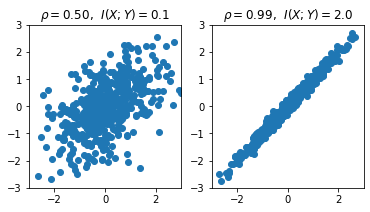

In [10]:
plt.figure(figsize=(6,3))
for i, rho in enumerate([0.5, 0.99]):
  plt.subplot(1, 2, i + 1)
  x, y = sample_correlated_gaussian(batch_size=500, dim=1, rho=rho)
  plt.scatter(x[:, 0], y[:, 0])
  plt.title(r'$\rho=%.2f$,  $I(X; Y)=%.1f$' % (rho, rho_to_mi(1, rho)))
  plt.xlim(-3, 3); plt.ylim(-3, 3);

### Training code

In [11]:
"""
LOOP FOR VARIATIONAL ESTIMATORS
"""
def train_variational_estimator(critic_params, data_params, mi_params):
  """Main training loop that estimates time-varying MI."""
  # Ground truth rho is only used by conditional critic
  critic = CRITICS[mi_params.get('critic', 'concat')](rho=None, **critic_params)

  baseline = BASELINES[mi_params.get('baseline', 'constant')]()
  
  opt = tf.keras.optimizers.Adam(opt_params['learning_rate'])
  
  @tf.function
  def train_step(rho, data_params, mi_params):
    # Annoying special case:
    # For the true conditional, the critic depends on the true correlation rho,
    # so we rebuild the critic at each iteration.
    if mi_params['critic'] == 'conditional':
      critic_ = CRITICS['conditional'](rho=rho)
    else:
      critic_ = critic
    with tf.GradientTape() as tape:
      x, y = sample_correlated_gaussian(dim=data_params['dim'], rho=rho, batch_size=data_params['batch_size'])
      mi = estimate_mutual_information(mi_params['estimator'], x, y, critic_, baseline, mi_params.get('alpha_logit', None))
      loss = -mi
  
      trainable_vars = []
      if isinstance(critic, tf.keras.Model):
        trainable_vars += critic.trainable_variables 
      if isinstance(baseline, tf.keras.Model):
        trainable_vars += baseline.trainable_variables
      grads = tape.gradient(loss, trainable_vars)
      opt.apply_gradients(zip(grads, trainable_vars))
    return mi
  
  # Schedule of correlation over iterations 
  mis = mi_schedule(opt_params['iterations'])
  rhos = mi_to_rho(data_params['dim'], mis)
  
  estimates = []
  for i in range(opt_params['iterations']):
                
    if (i+1) % 100000 == 0:
        print(i)
    estimates.append(train_step(rhos[i], data_params, mi_params).numpy())

  return np.array(estimates)

"""
Trains an estimator for CLUB
Adapted from https://github.com/Linear95/CLUB
"""
def train_club_estimator(critic_params, data_params, mi_params):

    mis = mi_schedule(opt_params['iterations'])
    rhos = mi_to_rho(data_params['dim'], mis)
    
    critic = CRITICS['CLUB'](data_params['dim'], data_params['dim'], 15)
    
    critic = critic.cuda()
    optimizer = torch.optim.Adam(critic.parameters(), lr=opt_params['learning_rate'])
    
    # start training loop
    estimates = []
        
    for i in range(opt_params['iterations']):
        x, y = sample_correlated_gaussian(dim=data_params['dim'], rho=rhos[i], batch_size=data_params['batch_size'])
        
        x = torch.from_numpy(x.numpy()).cuda()
        y = torch.from_numpy(y.numpy()).cuda()
        
        critic.eval()
        estimates.append(critic(x, y).item())
        
        critic.train()
        loss = critic.learning_loss(x, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if not (i % 1000):
            print(i, estimates[-1])
        

    return np.array(estimates)

"""
LOOP FOR MATRIX-BASED ESTIMATORS
"""
def train_rep_mi(estimator, data_params, mi_params, opt_params, critic_name, use_normalization=False):
    # initialize data parameters
    mis = mi_schedule(opt_params['iterations'])
    rhos = mi_to_rho(data_params['dim'], mis)
    
    # initialize sigma critic
    initial_sigma = torch.tensor(data_params['dim']**0.5)
    print(estimator)
    
    if estimator == 'DiMEo' or estimator == 'MBMIo':
        critic = CRITICS[critic_name](sigma_x_init=initial_sigma, sigma_y_init=initial_sigma, override=True)
    else:
        critic = CRITICS[critic_name](sigma_x_init=initial_sigma, sigma_y_init=initial_sigma)
    
    critic = critic.cuda()
    optimizer = torch.optim.Adam(critic.parameters(), lr=opt_params['learning_rate'])
    
    # start training loop
    estimates = [] 
    for i in range(opt_params['iterations']):
        x, y = sample_correlated_gaussian(dim=data_params['dim'], rho=rhos[i], batch_size=data_params['batch_size'])
        
        x = torch.from_numpy(x.numpy()).cuda()
        y = torch.from_numpy(y.numpy()).cuda()
        
        
        if estimator == 'MBMId':
            critic.sigma_x = torch.nn.Parameter(torch.tensor(opt_params['sigmax'][i]))
            critic.sigma_y = torch.nn.Parameter(torch.tensor(opt_params['sigmay'][i]))
            
            
        if i > 0 and critic_name == "RFF":
            Kx, Ky = critic(x, y, Kx, Ky)
        else:
            Kx, Ky = critic(x, y)
        
        if not i % 1000:
            print(i)
            
        if estimator == 'DiME Alpha=2':
            mi = -dent.doe(Kx, Ky, alpha=2, n_iters=1)
        
        elif estimator == 'DiME' or estimator=='DiMEo' or estimator == 'Alpha=1.01 DoE':
            mi = -dent.doe(Kx, Ky, alpha=1.01, n_iters=1)
            
        elif estimator == 'MBMI' or estimator == 'MBMIo' or estimator == 'MBMId':
            mi = -itl.matrixAlphaMutualInformation(Kx, Ky, alpha=1.01)
            
        elif estimator == 'Exact DIP':
            mi = dent.exact_dip(Kx, Ky)

        elif estimator == 'Alpha=1.01 DIP':
            mi = dent.dip(Kx, Ky, alpha=1.01, n_iters=1)
        
        elif estimator == 'Alpha=2 DIP':
            mi = dent.dip(Kx, Ky, alpha=1.01, n_iters=1)
        
        else:
            raise ValueError("INVALID ESTIMATOR NAME")       
        
        if estimator not in ['DiMEo', 'MBMIo', 'MBMId']:
            optimizer.zero_grad()
            mi.backward()
            optimizer.step()
            
        Kx = Kx.cpu().detach()
        Ky = Ky.cpu().detach()
        
        last_sig = critic.history_sigma_x[-1]
        estimates.append(np.abs(mi.item()))

    plot_sigmas(critic, estimator)
    return np.array(estimates), critic.history_sigma_x, critic.history_sigma_y



def plot_sigmas(critic, title):
    n = len(critic.history_sigma_x)
    
    full_title = "Kernel Bandwidths for " + title
    
    plt.plot(list(range(n)), critic.history_sigma_x, label="X Kernel Bandwidth")
    plt.plot(list(range(n)), critic.history_sigma_y, label="Y Kernel Bandwidth")
    
    plt.title(full_title)
    plt.xlabel("Steps")
    plt.ylabel("Value of Kernel Bandwidth")
    plt.legend()
    plt.show()

# Comparison of DiME with variational bounds methods

Build a dictionary of the mutual information estimators to train and their parameters.

Dataset, optimization, and critic parameters. Try experimenting with these.




In [17]:
data_params = {
    'dim': 20,
    'batch_size': 64
}

critic_params = {
    'layers': 2,
    'embed_dim': 32,
    'hidden_dim': 256,
    'activation': 'relu',

}

opt_params = {
    'iterations': 20000,
    'learning_rate': 5e-4,
}

critic_type = 'concat' #'concat' or 'separable'

In [13]:
# if you have results saved, can load them here
# import pickle

# with open('saved_results.pkl', 'rb') as f:
#     new_estimates = pickle.load(f)

Train each estimator and store mutual information estimates

Training DiMEo...
DiMEo
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


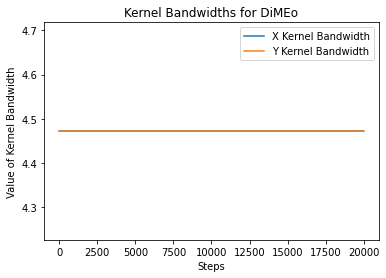

Training DiME...
DiME
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


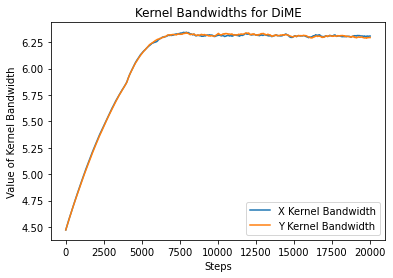

Training MBMIo...
MBMIo
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


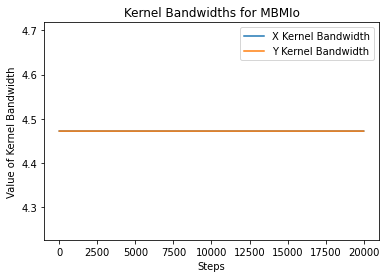

Training JS...
Training NWJ...
Training InfoNCE...
Training CLUB...
0 0.005973935127258301
1000 0.9204384684562683
2000 1.1642526388168335
3000 1.0878901481628418
4000 1.525545358657837
5000 2.417435884475708
6000 2.5607430934906006
7000 2.511406660079956
8000 3.282683849334717
9000 4.028967380523682
10000 5.258551120758057
11000 4.8381218910217285
12000 5.921239852905273
13000 8.015155792236328
14000 7.6586809158325195
15000 8.663195610046387
16000 10.779414176940918
17000 10.7083101272583
18000 9.38298511505127
19000 13.346525192260742


In [18]:
new_estimators = {
    'DiMEo': dict(estimator='DoMI', critic='sigma', alpha_logit=1.01),   #dime without bandwidth optimization
     'DiME': dict(estimator='DoMI', critic='sigma', alpha_logit=1.01),   # dime with bandwidth optimization
    'MBMIo': dict(estimator='DoMI', critic='sigma', alpha_logit=1.01),   # mbmi without bandwidth optimization
     'JS': dict(estimator='js', critic=critic_type, baseline='constant'),
     'NWJ': dict(estimator='nwj', critic=critic_type, baseline='constant'),
     'InfoNCE': dict(estimator='infonce', critic=critic_type, baseline='constant'),
    'CLUB': dict(estimator='club', critic='club', baseline='constant'),
#'MBMI': dict(estimator='DoMI', critic='sigma', alpha_logit=1.01),    # mbmi with bandwidth optimization (goes to trivial solution)
    #    'Exact DIP': dict(estimator='DoMI', critic='sigma', alpha_logit=2),    #DIP is DiME without logs
#     'Alpha=1.01 DIP': dict(estimator='DoMI', critic='sigma', alpha_logit=1.01),
#'Alpha=2 DIP': dict(estimator='DoMI', critic='sigma', alpha_logit=2),
# 'TUBA': dict(estimator='tuba', critic=critic_type, baseline='unnormalized'),
}

new_estimates = {}
new_timers = {}

for estimator, mi_params in new_estimators.items():
  print("Training %s..." % estimator)
  timestart = time.time()
  
  # based on method, go to correct training loop
  if 'DiME' in estimator or 'DIP' in estimator or 'MBMI' in estimator:
    new_estimates[estimator], sigx, sigy = train_rep_mi(estimator, data_params, mi_params, opt_params, critic_name=mi_params['critic'])
    opt_params['sigmax'] = sigx
    opt_params['sigmay'] = sigy
  elif 'CLUB' in estimator:
    new_estimates[estimator] = train_club_estimator(critic_params, data_params, mi_params)
  else:
    new_estimates[estimator] = train_variational_estimator(critic_params, data_params, mi_params)
                                               
  new_timers[estimator] = time.time()-timestart

# save results to file
with open('saved_results.pkl', 'wb') as f:
    pickle.dump(new_estimates, f)                                

# Proportion Graphs

['DiMEo', 'DiME', 'MBMIo', 'JS', 'NWJ', 'InfoNCE', 'CLUB']
DiMEo
DiME
MBMIo
JS
NWJ
InfoNCE


No handles with labels found to put in legend.


CLUB


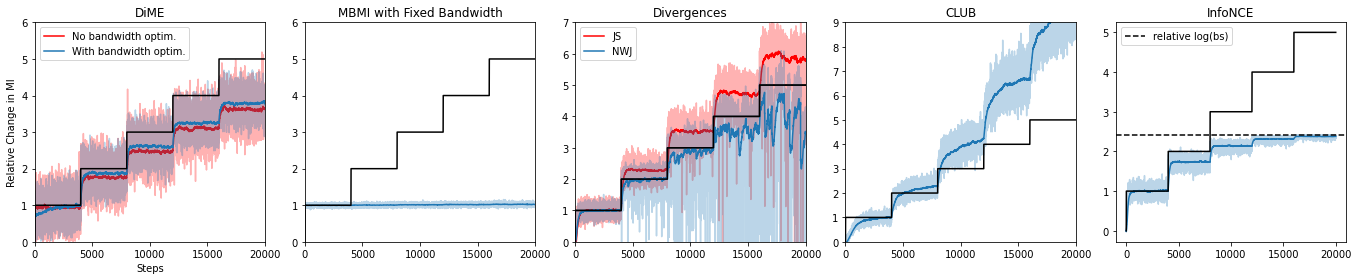

In [19]:
full_estimators = new_estimators.copy()

full_estimates = new_estimates.copy()

if 'MBMId' in full_estimators.keys():
    full_estimates.pop('MBMId')
    full_estimators.pop('MBMId')
# Smooting span for Exponential Moving Average
EMA_SPAN = 200

# Ground truth MI
mi_true = mi_schedule(opt_params['iterations'])
#truncate mi_true to 16k and make it relative
mi_true = np.array([m / mi_true[1] for m in mi_true])

# Names specifies the key and ordering for plotting estimators
names = list(full_estimators.keys())
print(names)
lnames = list(map(lambda s: s.replace('alpha', '$\\alpha$'), names))

nrows = min(1, len(full_estimates))

ncols = 5 #int(np.ceil(len(full_estimates) / float(nrows)))
fig, axs = plt.subplots(nrows, ncols, figsize=(3.8 * ncols, 4 * nrows)) 
if len(full_estimates) == 1:
  axs = [axs]
axs = np.ravel(axs)

qq = []

mbmitwin = 0

for i, name in enumerate(names):
  print(name)

  if i < 2:
      plt.sca(axs[0])
  
  elif name in ['MBMIo']:
    plt.sca(axs[1])
  elif name in ['JS, NWJ']:
    plt.sca(axs[2])
    
  elif name in ['infoNCE']:
    plt.sca(axs[4])
  elif name in ['CLUB']:
    plt.sca(axs[3])
        
  if name!='DiME' and 'DIP' not in name and 'Eigen' not in name and 'Memory' not in name: # and 'NCE' not in name:
    plt.ylim(0, mi_true.max()+1)
    plt.xlim(0, opt_params['iterations'])

  elif name != 'DiME':
    plt.ylim(min(mis), max(mis)*1.2)
    plt.xlim(0, opt_params['iterations'])
  
  if lnames[i] == 'DiMEo':
      plt.title('DiME')
  elif lnames[i] == 'MBMIo':
      plt.title('MBMI with Fixed Bandwidth')
  elif lnames[i] == 'MBMI':
      plt.title('MBMI with Bandwidth Optimization')
  elif lnames[i] in ['NWJ', 'JS']:
    axs[2].set_title("Divergences")
  elif lnames[i] == 'InfoNCE':
        axs[4].set_title("InfoNCE")
  elif lnames[i] == 'CLUB':
    axs[3].set_title("CLUB")
    
  # Plot estimated MI and smoothed MI
  mis = full_estimates[name]
  # fully trained value for MI=2. assumes niters=20000

  last_mi2 = np.mean(mis[3900:3999])
  mis = [m / last_mi2 for m in mis] # make mis proportional 

  mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
  
  if name == 'DiME':
      pp = axs[0].plot(mis, alpha=0.3, c='#1f77b4')[0]
      pp = axs[0].plot(mis_smooth, c=pp.get_color(), label='With bandwidth optim.')
        
      axs[0].set_xlim(0, opt_params['iterations'])
      
      lns = qq[0] + pp
      labs = [l.get_label() for l in lns]
      axs[0].legend(lns, labs, loc=0)
      qq = []
        
      axs[0].plot(mi_true, color='k')

  elif name == 'DiMEo'or name=='RFF':
      plt.xlim(0, opt_params['iterations'])
      axs[0].plot(mis, alpha=0.3, c='red')[0]
      jj = axs[0].plot(mis_smooth, c='red', label='No bandwidth optim.')
        
      qq = [jj]
        
  elif name == 'MBMIo':

      plt.xlim(0, opt_params['iterations'])
    
      if name == 'MBMI':
          c = '#1f77b4'
      else:
          c = '#1f77b4'
            
      axs[1].plot(mis, alpha=0.3, c=c)[0]
    
      if name == 'MBMIo':
          l = 'With fixed Bandwidth'
      
      jj = axs[1].plot(mis_smooth, c=c, label=l)
      qq.append(jj)
      axs[1].legend().remove()
        
      axs[1].plot(mi_true, color='k')
    
  elif name == 'NWJ':
      axt = axs[2]
      pp = axt.plot(mis, alpha=0.3)[0]
      pp = axt.plot(mis_smooth, c=pp.get_color(), label='NWJ')
        
      axt.set_ylim(0, 7)
      axt.set_xlim(0, opt_params['iterations'])
      
      lns = jj + pp
      labs = [l.get_label() for l in lns]
      axt.legend(lns, labs, loc=0)
      qq = []
    
      axs[2].plot(mi_true, color='k')

  elif name == 'JS':
      axt = axs[2]
      axt.set_ylim(0, 7)
      plt.xlim(0, opt_params['iterations'])
      axt.plot(mis, alpha=0.3, c='red')[0]
      jj = axt.plot(mis_smooth, c='red', label='JS')
      axt.plot(mi_true, color='k')
    
  elif name == 'InfoNCE':
      p1 = axs[4].plot(mis, alpha=0.3)[0]
      axs[4].plot(mis_smooth, c=p1.get_color())
      axs[4].axhline(np.log(data_params['batch_size'])/last_mi2, c='k', linestyle='--', label=r'relative log(bs)' )
      axs[4].legend()
      axs[4].plot(mi_true, color='k')
    
  elif name == 'CLUB':
      axs[3].set_ylim(0, 9)
      p1 = axs[3].plot(mis, alpha=0.3)[0]
      axs[3].plot(mis_smooth, c=p1.get_color())
      axs[3].plot(mi_true, color='k')

  # Plot true MI and line for log(batch size)
  estimator = full_estimators[name]['estimator']

  if i == 0:
    axs[i].set_xlabel('Steps')
    axs[i].set_ylabel('Relative Change in MI')
    

plt.legend(loc='best', fontsize=8, framealpha=0.0)
plt.gcf().tight_layout();

# Value Graphs

No handles with labels found to put in legend.
No handles with labels found to put in legend.


['DiMEo', 'DiME', 'MBMIo', 'JS', 'NWJ', 'InfoNCE', 'CLUB']
DiMEo
DiME
MBMIo
JS
NWJ
InfoNCE
CLUB


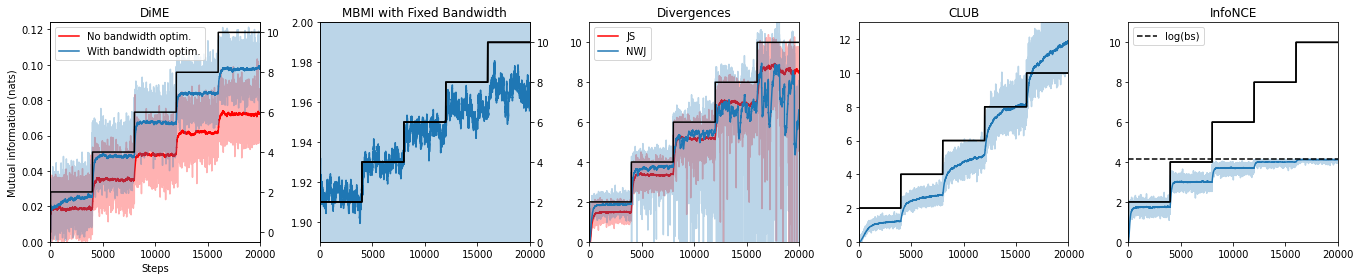

In [23]:
full_estimators = new_estimators.copy()

full_estimates = new_estimates.copy()


# full_estimates.pop('MBMIo')
# full_estimators.pop('MBMIo')
# Smooting span for Exponential Moving Average
EMA_SPAN = 200

# Ground truth MI
mi_true = mi_schedule(opt_params['iterations'])

# Names specifies the key and ordering for plotting estimators
names = list(full_estimators.keys())
print(names)
lnames = list(map(lambda s: s.replace('alpha', '$\\alpha$'), names))

nrows = min(1, len(full_estimates))

ncols = 5 #int(np.ceil(len(full_estimates) / float(nrows)))
fig, axs = plt.subplots(nrows, ncols, figsize=(3.8 * ncols, 4 * nrows)) 
if len(full_estimates) == 1:
  axs = [axs]
axs = np.ravel(axs)

qq = []

mbmitwin = 0

for i, name in enumerate(names):
  print(name)

  if i < 2:
      plt.sca(axs[0])
  
  elif name in ['MBMIo']:
    plt.sca(axs[1])
  elif name in ['JS, NWJ']:
    plt.sca(axs[2])
  elif name in ['InfoNCE']:
    plt.sca(axs[4])
  elif name in ['CLUB']:
    plt.sca(axs[3])

        
  if name!='DiME' and 'DIP' not in name and 'Eigen' not in name and 'Memory' not in name: # and 'NCE' not in name:
    plt.ylim(0, mi_true.max()+1)
    plt.xlim(0, opt_params['iterations'])
    
    if name in ['DiMEo']:
        axs[0].twinx().plot(mi_true, color='k')
    elif name in ['MBMIo']:
        axs[1].twinx().plot(mi_true, color='k')
    elif name not in ['infoNCE', 'JS']:
        plt.plot(mi_true, color='k')

    else:
        plt.plot(mi_true, color='k', label='True MI')
    
  elif name != 'DiME':
    plt.ylim(min(mis), max(mis)*1.2)
    plt.xlim(0, opt_params['iterations'])
  
  if lnames[i] == 'DiMEo':
      plt.title('DiME')
  elif lnames[i] == 'MBMIo':
      axs[1].set_title('MBMI with Fixed Bandwidth')
  elif lnames[i] in ['NWJ', 'JS']:
    axs[2].set_title("Divergences")

  elif lnames[i] not in ["DiME", "MBMI", "MBMIo", "JS"]:
    plt.title(lnames[i])
    
  # Plot estimated MI and smoothed MI
  mis = full_estimates[name]

  if 'DiME' in name:
    mis = full_estimates[name]
    
    if 'DiMEo' in name:
        maxxer = np.max(mis)*1.2
        
  mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
  
  if name == 'DiME':
      axt = axs[0]
      pp = axt.plot(mis, alpha=0.3, c='#1f77b4')[0]
      pp = axt.plot(mis_smooth, c=pp.get_color(), label='With bandwidth optim.')
        
      axt.set_ylim(0, maxxer)
      axt.set_xlim(0, opt_params['iterations'])
      
      lns = qq[0] + pp
      labs = [l.get_label() for l in lns]
      axs[0].legend(lns, labs, loc=2)
      qq = []

  elif name == 'DiMEo'or name=='RFF':
      axt = axs[0]
      axt.set_ylim(0, maxxer)
      plt.xlim(0, opt_params['iterations'])
      axt.plot(mis, alpha=0.3, c='red')[0]
      jj = axt.plot(mis_smooth, c='red', label='No bandwidth optim.')
        
      qq = [jj]
      
      axt.legend().remove()
    
  elif name == 'MBMIo':
      axt = axs[1]
      pp = axt.plot(mis, alpha=0.3, c='#1f77b4')[0]
      pp = axt.plot(mis_smooth, c=pp.get_color())
    
      axt.set_ylim(1.89, 2.0)
      axt.set_xlim(0, opt_params['iterations'])

      axt.legend().remove()
    
  elif name == 'NWJ':
    
      axt = axs[2]
      pp = axt.plot(mis, alpha=0.3)[0]
      pp = axt.plot(mis_smooth, c=pp.get_color(), label='NWJ')
  
      axt.set_ylim(0, 11)
      axt.set_xlim(0, opt_params['iterations'])
      
      lns = jj + pp
      labs = [l.get_label() for l in lns]
      axt.legend(lns, labs, loc=0)
      qq = []
    
      axs[2].plot(mi_true, color='k')

  elif name == 'JS':
      axt = axs[2]
      axt.set_ylim(0, 11)
      plt.xlim(0, opt_params['iterations'])
      axt.plot(mis, alpha=0.3, c='red')[0]
      jj = axt.plot(mis_smooth, c='red', label='JS')
    
  elif name == 'InfoNCE':
      p1 = axs[4].plot(mis, alpha=0.3)[0]
      axs[4].plot(mis_smooth, c=p1.get_color())
      axs[4].axhline(np.log(data_params['batch_size']), c='k', linestyle='--', label='log(bs)' )
      axs[4].legend()
      axs[4].plot(mi_true, color='k')
    
  elif name == 'CLUB':
      axs[3].set_ylim(0, 13)
      p1 = axs[3].plot(mis, alpha=0.3)[0]
      axs[3].plot(mis_smooth, c=p1.get_color())
      axs[3].plot(mi_true, color='k')
    
  else:
      print('dont be here', name)
      p1 = plt.plot(mis, alpha=0.3)[0]

      plt.plot(mis_smooth, c=p1.get_color())

  # Plot true MI and line for log(batch size)
  estimator = full_estimators[name]['estimator']


  if i == 0:
    axs[i].set_xlabel('Steps')
    axs[i].set_ylabel('Mutual information (nats)')
    
plt.legend(loc='best', fontsize=8, framealpha=0.0)
plt.gcf().tight_layout();

# Behavior wrt bandwidth

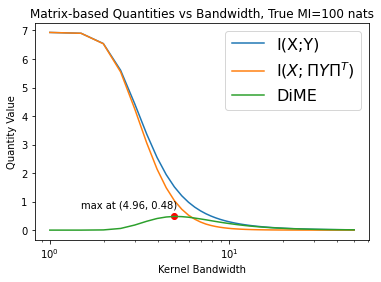

In [21]:
rho = mi_to_rho(20, 100)
x, y = sample_correlated_gaussian(batch_size=1024, dim=20, rho=rho)

x = torch.from_numpy(x.numpy()).cuda()
y = torch.from_numpy(y.numpy()).cuda()

sigma = np.linspace(1, 50, 100)
mbmi_paired = [itl.matrixAlphaMutualInformation(ku.gaussianKernel(x, x, s), ku.gaussianKernel(y, y, s), alpha=1.01) for s in sigma]
mbmi_unpaired = [itl.matrixAlphaMutualInformation(ku.gaussianKernel(x, x, s), dent.permuteGram(ku.gaussianKernel(y, y, s)), alpha=1.01) for s in sigma]
dime = [abs(mbmi_paired[i] - mbmi_unpaired[i]) for i in range(100)]

dime_maxy = max(dime).item()
dime_maxpos = dime.index(dime_maxy)
dime_maxsigma = sigma[dime_maxpos]

plt.plot(dime_maxsigma, dime_maxy, 'ro')
plt.text(1.5, dime_maxy+0.3, 'max at (%.2f, %.2f)' % (dime_maxsigma, dime_maxy))

plt.xscale('log')
plt.plot(sigma, mbmi_paired, label='I(X;Y)')
plt.plot(sigma, mbmi_unpaired, label=r'I$(X;\Pi Y \Pi^T)$')
plt.plot(sigma, dime, label='DiME')
plt.title('Matrix-based Quantities vs Bandwidth, True MI=100 nats')
plt.xlabel('Kernel Bandwidth')
plt.ylabel('Quantity Value')
plt.legend(prop={'size': 16})